# <center> Proyección de la demanda de una tienda delicatessen </center>

Predecir la demanda de un comercio, ya sea a través de las ventas, del número de clientes o de las compras, es útil para ajustar niveles de producción, stocks y personal de la manera más eficiente posible; es decir, reducir al máximo los costes garantizando la demanda y la atención al cliente. 

Para ello, encontrar los patrones estacionales de los datos es esencial, estos patrones revelarán el comportamiento de las ventas en el tiempo para poder proyectarlas.  

Primero buscaré el modelo de series temporales a utilizar analizando la estacionalidad y la autocorrelación de mi serie para elegir el modelo que mejor se ajuste a las características de mis datos. Después adecuaré los datos al modelo elegido, hare un cross validation y, con los mejores hiperparámetros, entrenaré y ajustaré el modelo. Finalmente haré las proyecciones, analizaré su ajuste y concluiré. 

In [20]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import statsmodels.api as sm
import numpy as np
import matplotlib.dates as mdates
from math import ceil
from datetime import datetime, timedelta
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from scipy import stats
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['xtick.minor.bottom'] = False
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

dayofweek_colors = {0: 'tab:blue', 1: 'tab:orange',
                    2: 'tab:green', 3: 'tab:red', 
                    4: 'tab:purple', 5: 'tab:brown', 
                    6: 'tab:pink'}

**Cargo un dataframe (Fac)** que contiene las ventas diarias en € de la tienda. Un total de ocho años, del año 2015 al 2023. Busco predecir las ventas diarias de 2024 y 2025. 

In [4]:
Fac = pd.read_csv('C:\\Juan\\ITAcademy\\Proyecto\\Cuentas_DGusta2.csv',encoding='latin-1',sep=';')

Creo una nueva columna para numerar los días de la semana del 0 al 6, donde 0 es lunes y 6 domingo (el dataset comienza un jueves)), reorganizo columnas, cambio de nombres algunas columnas y convierto las columnas 'Ventas' y 'Fecha' a formatos numéricos y de fecha, respectivamente. 

In [5]:
Fac['Numero_dia'] = (Fac.index + 3) % 7
Fac = Fac.reindex(columns=["Día", "Numero_dia", "Fecha", "Ventas", "Num Ventas" ,"Días festivos", "Domingos", "Cerrado"])
Fac.rename(columns={ 'Numero_dia': 'Num_Día','Días festivos': 'Festivos'}, inplace=True)
Fac["Ventas"] = Fac["Ventas"].str.replace(',', '.').astype(float)
#Fac["Num Ventas"] = Fac["Num Ventas"].replace(',', '.').astype(int)
Fac['Fecha'] = pd.to_datetime(Fac['Fecha'], format='%d/%m/%Y')

In [6]:
Fac.dtypes

Día                   object
Num_Día                int64
Fecha         datetime64[ns]
Ventas               float64
Num Ventas             int64
Festivos               int64
Domingos               int64
Cerrado                int64
dtype: object

Cambio el nombre de la columna temporal Fecha y la de la variable objetivo Ventas por "ds" e "y" respectivamente. **Nota aclaratoria**: con antelación a este documento ya hice el análisis de estacionalidad y autocorrelación, ya sé que modelo usaré. Por exigencias del modelo elegido, he de renombrar estas variables como "ds" e "y". 

In [7]:
Fac.rename(columns={'Fecha':'ds', 'Ventas':'y'}, inplace=True)

In [8]:
Fac

,Día,Num_Día,ds,y,Num Ventas,Festivos,Domingos,Cerrado
0,Jueves,3,2015-01-01,0.00,0,1,0,1
1,Viernes,4,2015-01-02,995.27,43,0,0,0
2,Sábado,5,2015-01-03,826.49,45,0,0,0
3,Domingo,6,2015-01-04,0.00,0,0,1,1
4,Lunes,0,2015-01-05,555.79,18,0,0,0
...,...,...,...,...,...,...,...,...
3282,Miércoles,2,2023-12-27,1831.71,115,0,0,0
3283,Jueves,3,2023-12-28,4161.24,262,0,0,0
3284,Viernes,4,2023-12-29,3059.79,192,0,0,0
3285,Sábado,5,2023-12-30,3317.08,209,0,0,0


In [9]:
Fac.describe()

,Num_Día,ds,y,Num Ventas,Festivos,Domingos,Cerrado
count,3287.000000,3287,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000
mean,3.001825,2019-07-01 23:59:59.999999744,1080.488016,74.512017,0.038941,0.142988,0.181929
min,0.000000,2015-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2017-04-01 12:00:00,718.000000,48.000000,0.000000,0.000000,0.000000
50%,3.000000,2019-07-02 00:00:00,1059.960000,73.000000,0.000000,0.000000,0.000000
75%,5.000000,2021-09-30 12:00:00,1421.710000,97.000000,0.000000,0.000000,0.000000
max,6.000000,2023-12-31 00:00:00,7280.580000,1756.000000,1.000000,1.000000,1.000000
std,2.000151,NaN,795.697791,62.068232,0.193484,0.350113,0.385845


Veo que no haya datos nulos

In [10]:
Fac[Fac.isnull()].count()

Día           0
Num_Día       0
ds            0
y             0
Num Ventas    0
Festivos      0
Domingos      0
Cerrado       0
dtype: int64

Busco si existen fechas duplicadas

In [11]:
Fac[Fac.ds.duplicated()]['ds'].count()

0

Fechas de inicio y fin de la serie y total de días

In [12]:
print('Fecha inicio de la serie: ', Fac.ds.min())
print('Fecha fin de la serie: ', Fac.ds.max())
print('Número total de días: ', Fac.ds.nunique())

Fecha inicio de la serie:  2015-01-01 00:00:00
Fecha fin de la serie:  2023-12-31 00:00:00
Número total de días:  3287


La tienda abre de lunes a sábado. Verifico no tener ventas los domingos, día número 6.  

In [13]:
Fac[Fac['y'] > 0].groupby(Fac.ds.dt.dayofweek).count()[['y']].rename(columns={'y': 'count'})

,count
ds,
0,432
1,450
2,449
3,455
4,445
5,458


In [25]:
correlacion, valor_p = pearsonr(Fac['y'], Fac['Num Ventas'])
print("La correlación entre -y- y Num Ventas es:", correlacion)
print("El valor p es:", valor_p)

La correlación entre -y- y Num Ventas es: 0.8396704939089477
El valor p es: 0.0


La correlación entre las ventas en € ("y") y el número de ventas o clientes ("Num_Ventas") es alta y positiva. Cuando una de las dos variables aumenta la otra tiende a aumentar también y viceversa. 

Además, esta correlación es significativa, el valor p de la prueba de hipótesis es cero (p < 0.05). La **hipótesis nula** de no correlación es rechazada en favor de la alternativa de **existe correlación**. 

En resumen, la correlación de 0.84 (con valor p=0) entre ventas en € y número de ventas, indica una fuerte relación positiva entre las dos variables, lo que sugiere que hay una asociación significativa entre ellas. 

### **Estacionalidad y autocorrelación de la serie de tiempo**

#### **Estacionalidad**

**Gráfico de histórico de ventas**

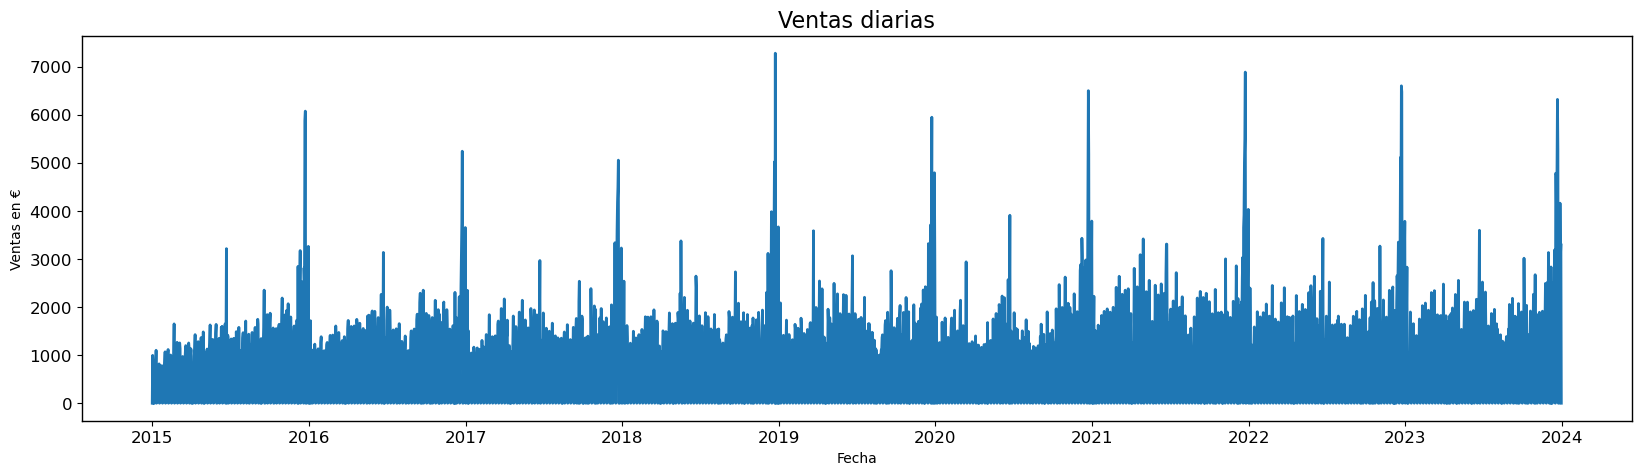

In [44]:
plt.figure(figsize=(20, 5))
ax = sns.lineplot(x=Fac['ds'], y=Fac['y'])
plt.xlabel('Fecha')
plt.ylabel('Ventas en €')
plt.title('Ventas diarias', fontsize=16)
plt.show()

En el gráfico se observa estacionalidad año con año, las ventas a principio de cada año comienzan en su nivel más bajo, suben rápidamente hasta un nivel donde tienen diferentes picos a lo largo de los meses con una caida alrededor de noviembre. Finalmente comienzan a subir hasta la temporada navideña que es cuando alcanzan su máximo. **Nota**: cabe aclarar que en este documento, por temporada navideña o navidad, me refiero a las semanas 50, 51, 52 y 53 de cada año. Las ventas en estas fechas crecen con fuerza, desde aproximadamente el día 10 o 11 de diciembre hasta la semana de reyes en enero. 

Se aprecia también una ligera tendencia de crecimiento a la largo de los años y, desde 2021, se observa un sutil cambio en esta estacionalidad, las ventas suben y parecen más constantes, se mantienen los picos en los meses y las ventas navideñas con el máximo de ventas. 

En general parece existir un patrón estacional complejo. 

**Gráficos de tendencia  y estacionalidad**

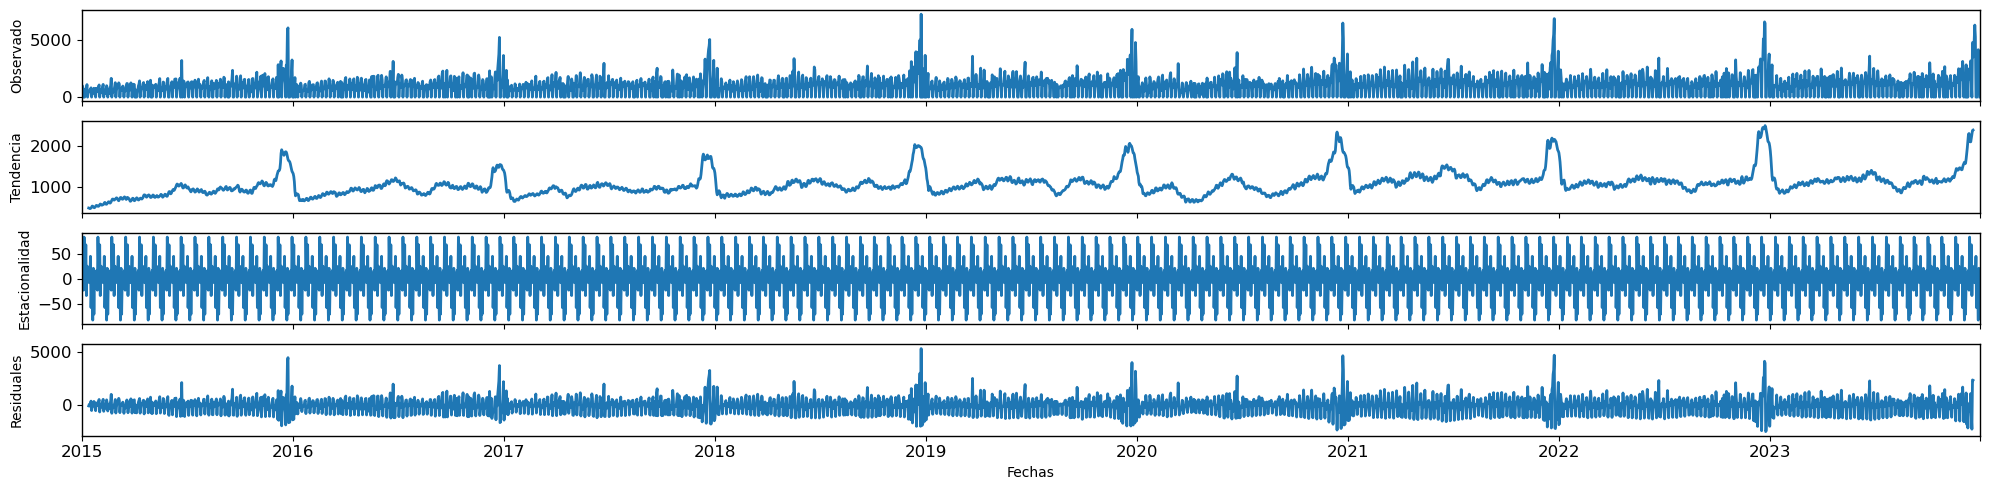

In [45]:
res = seasonal_decompose(Fac.set_index('ds')['y'], model='additive', period=24)

def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observado')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Tendencia')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Estacionalidad')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residuales')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(20, 5))

plotseasonal(res, axes)

axes[3].set_xlabel('Fechas')

plt.tight_layout()
plt.show()

En estos gráficos se observa de forma más evidente la estacionalidad de los datos, sólo hace falta observar el gráfico de estacionalidad que matiene fluctuaciones constantes a lo largo del tiempo. El gráfico de tendencia muestra también una clara estacionalidad con un ligero crecimiento constante de la serie, es decir, no existen ningún evento en el tiempo que haya generado un punto de inflexión que tengamos que tomar en cuenta en el modelo (obras, efecto por COVID, más competencia, etc.).  

**Verifico formalmete la estacionalidad de la serie**: prueba de estacionalidad de Dickey- Fuller. 

In [46]:
result = adfuller(Fac['y'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.983099
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


**Hipótesis nula:** Los datos son no estacionarios. **Hipótesis alternativa:** Los datos son estacionarios. 

Como el valor p (0.00) es menor que el nivel de significancia de 0.05, o el el estadístico de prueba (-7.98) es menor que el valor crítico al 5% (-2.86), la decisión es rechazar la hipótesis nula. Los datos proporcionan evidencia de que son estacionarios.

#### **Autocorrelación**

**Gráfico de autocorrelación de la serie**

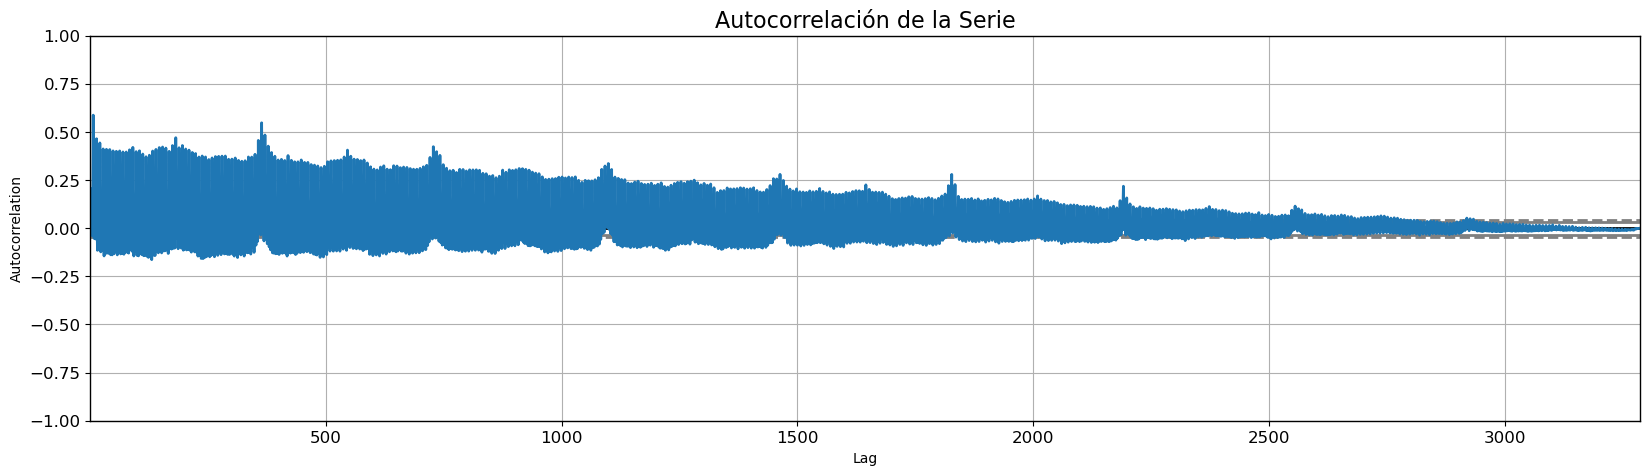

In [47]:
plt.figure(figsize=(20,5))
pd.plotting.autocorrelation_plot(Fac['y']);
plt.title('Autocorrelación de la Serie', fontsize=16)
plt.show()

**Gráficos de la función de autocorrelación**

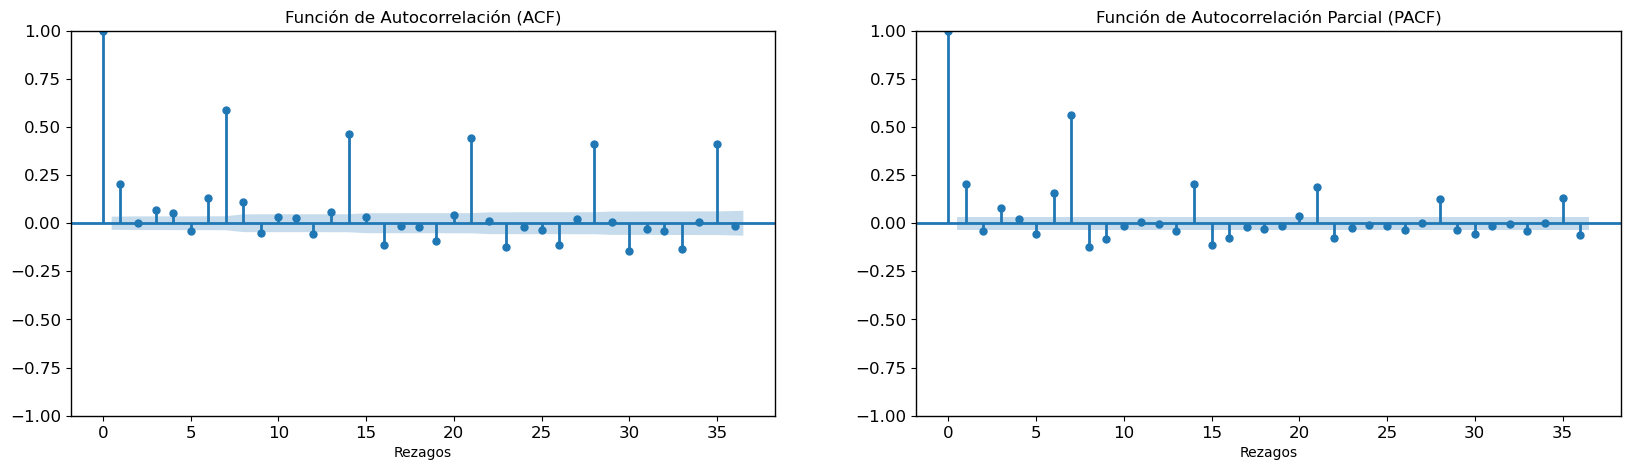

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
plot_acf(Fac['y'], ax=ax[0])
ax[0].set_title('Función de Autocorrelación (ACF)')
ax[0].set_xlabel('Rezagos')  
plot_pacf(Fac['y'], ax=ax[1])
ax[1].set_title('Función de Autocorrelación Parcial (PACF)')
ax[1].set_xlabel('Rezagos')  
plt.show()

**Prueba de autocorrelación de Durbin-Watson**

In [49]:
result = sm.stats.durbin_watson(Fac['y'])
print("Estadística de prueba de Durbin-Watson:", result)

Estadística de prueba de Durbin-Watson: 0.5590103299499654


Estos gráficos y la prueba de Durbin-Watson indican una autocorrelación positiva significativa y refuerzan el resultado de existencia de estacionalidad. 

La ACF mide la correlación lineal entre una serie de tiempo y sus versiones rezagadas (desplazadas en el tiempo) y la PACF mide la correlación entre dos puntos de tiempo teniendo en cuenta las contribuciones de los rezagos intermedios, ayuda a identificar la contribución específica de un rezago particular.

Los valores altos cíclicos en los gráficos ACF y PACF (en 0, 7, 14, 21, 28 y 35) indican una autorrelación estacional fuetre, el resto de autocorrelaciones, o están dentro de la franja de autocorrelación no significativa, o estan fuera, pero dentro de lo que un modelo que contemple la autocorrelación puede manejar, no se aprecian patrones dentro de estas autocorrelaciones. 

Según PACF parace existir contribución de un rezago en particular, además es cíclico y proporcional en el tiempo. Todo indica que es la época navideña. 

Los datos tienen autocorrelación positiva y significativa provocada por sólo un rezago cíclico. Cualquier modelo elegido debe tomar en cuenta esta correlación para que sus predicciones sean más ajustadas.  

#### **Periodicidad de la estacionalidad: diaria, semanal, mensual y anual**

**Gráfico de ventas por días de la semana** 

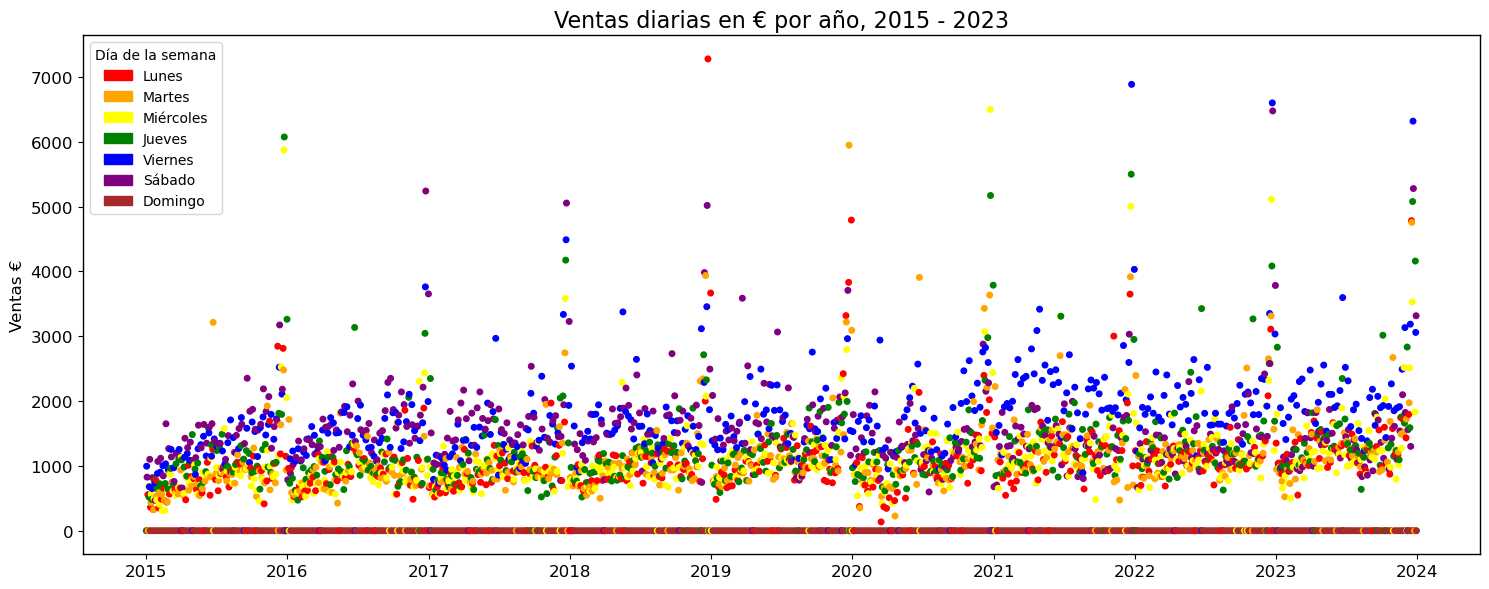

In [50]:
dayofweek_colors = {
    0: 'red',
    1: 'orange',
    2: 'yellow',
    3: 'green',
    4: 'blue',
    5: 'purple',
    6: 'brown'
}

dayofweek_names = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes',
    5: 'Sábado',
    6: 'Domingo'
}

plt.close()
fig, ax = plt.subplots(figsize=(15,6))
scatter = ax.scatter(Fac['ds'], Fac['y'], c=Fac['ds'].dt.dayofweek.map(dayofweek_colors))

handles = [mpatches.Patch(color=v, label=dayofweek_names[k]) for k, v in dayofweek_colors.items()]
legend = ax.legend(handles=handles, loc='upper left', title="Día de la semana")
ax.set_title("Ventas diarias en € por año, 2015 - 2023", fontsize=16)
ax.set_ylabel("Ventas €", fontsize=12)

plt.tight_layout()
plt.show()

En el gráfico se observa un patrón estacional por día y por semana. Las ventas diarias se mantienen en un rango de valores más o menos constante a lo largo del año: se vende menos los primeros meses del año, poco a poco se recuperan, y en la temporada navideña, las ventas diarias llegan a su máximo al igual que las semanales.

Por otro lado, a lo largo de los años no se observan cambios en el patrón, mantiene una ligera tendencia de crecimiento con fluctuaciones constantes. Es decir, las ventas y su disperción se mantienen constantes, con un ligero crecimiento, a lo largo de los años. Esto es indicativo de estacionalidad aditiva, no se observan variaciones ni en la amplitud ni en la frecuencia de las olas, usaremos entonces estacionalidad aditiva en el modelo. 

A finales de 2019 las ventas de los viernes aumentan y bajan las de los sábados, seguramente se debe a que la tienda cierra los sábados por la tarde desde finales de 2019. Desde esa fecha, los viernes y los sábados serían las observaciones que más se alejan del patrón que siguen el resto de datos. Además, desde 2021, las ventas de los viernes no parece que sigan un patrón definido. 

**Gráfico de ventas por semanas del mes**

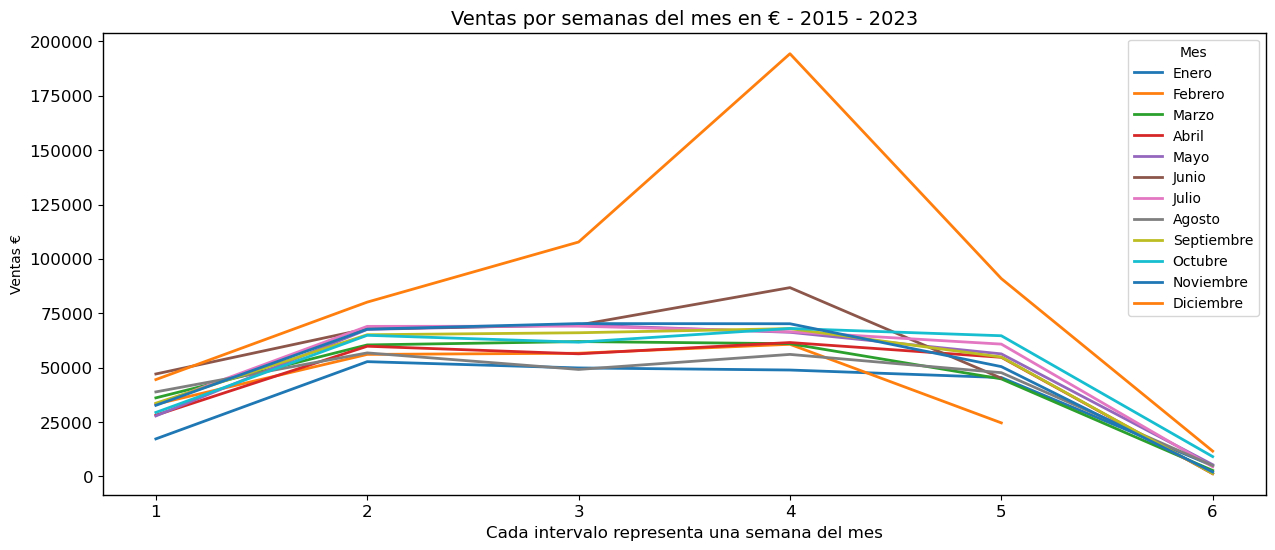

In [51]:
month_names = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril',
    5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
    9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
}

plt.close()
palette = sns.color_palette("tab10", 12)
fig, ax = plt.subplots(figsize=(15, 6))

por_meses = Fac[['ds', 'y']].copy()

def week_of_month(date):
    first_day = date.replace(day=1)
    day_of_month = date.day
    offset = (first_day.weekday() - 1 + day_of_month) // 7
    return offset + 1

por_meses['semana'] = por_meses.ds.apply(week_of_month) 
por_meses['mes'] = por_meses.ds.dt.month
por_meses = por_meses.groupby(['mes', 'semana']).agg({'y': 'sum'}).reset_index()

ax = sns.lineplot(x=por_meses['semana'], y=por_meses['y'], hue=por_meses['mes'], ax=ax, palette=palette)

handles, labels = ax.get_legend_handles_labels()
new_labels = [month_names[int(label)] for label in labels]
ax.legend(handles=handles, labels=new_labels, title="Mes")
ax.set_title("Ventas por semanas del mes en € - 2015 - 2023", fontsize=14)
ax.set_ylabel("Ventas €")
ax.set_xlabel("Cada intervalo representa una semana del mes", fontsize=12)

plt.show()

Agregando las ventas por semana, observamos un patrón estacional mensual. Se vende menos las primeras semanas del mes, suben las ventas hasta inicios de la semana 4, aquí llegan a su máximo coincidiendo con el pago a pensionistas; para volver a bajar los últimos días de la semana 4 y lo que resta de la que sería la semana 5.

**Gráfico de ventas por mes del año**

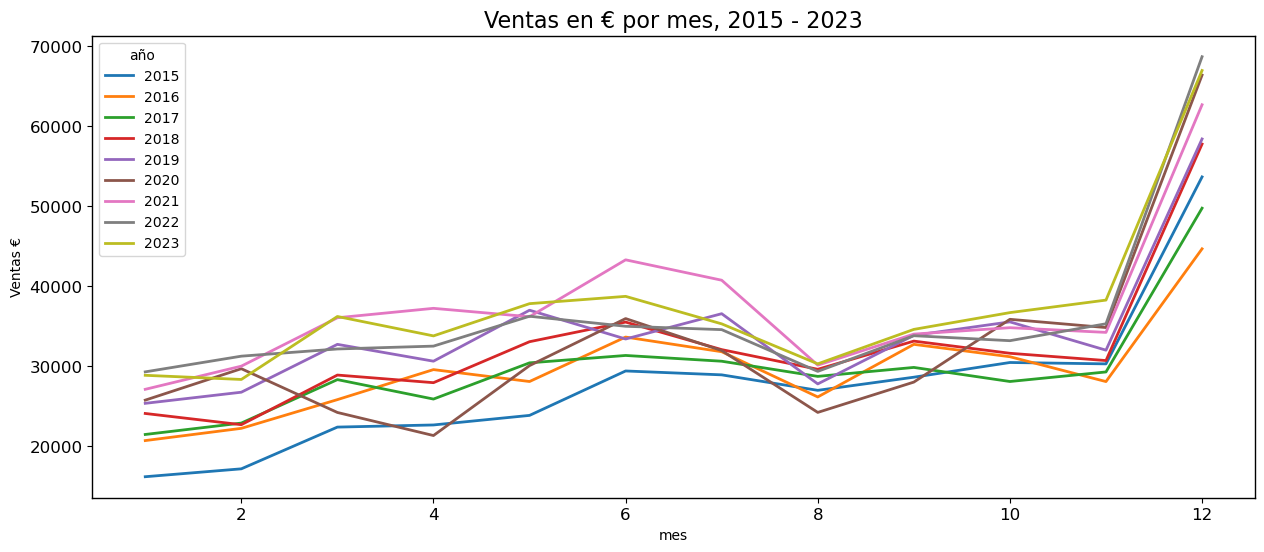

In [52]:
por_años = Fac[['ds', 'y']].copy()
por_años['año'] = por_años.ds.dt.year
por_años['mes'] = por_años.ds.dt.month

por_años = por_años.groupby(['año', 'mes'])['y'].sum().reset_index()

plt.close()
palette = sns.color_palette("tab10", n_colors=len(por_años['año'].unique()))
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.lineplot(x='mes', y='y', hue='año', data=por_años, ax=ax, palette=palette)
ax.set_title("Ventas en € por mes, 2015 - 2023", fontsize=16)
ax.set_ylabel("Ventas €")

plt.show()

En la gráfico de ventas por mes se observa estacionalidad anual. Las ventas tienen un tendencia creciente desde los primeros meses del año hasta el mes de julio. En agosto bajan y se recuperan entre septiembre y noviembre para llegar a su máximo diciembre. 
Las ventas también muestran una tendencia creciente de año en año: los años más recientes son los que presentan mayores ventas a lo largo de los meses. 

#### **Modelo a utilizar**

Los datos presentan una estacionalidad compleja que es tanto diaria como semanal, mensual y anual. También presentan autocorrelación significativa cíclica, e incorporan festivos y domingos como festivos, esos días no hay ventas. 

Dadas estas características, me parece que dos modelos de series de tiempo encajan bien: Prophet y los modelos de aprendizaje profundo como Redes Neuronales Recurrentes, sobre todo LSTM. 

Voy a elegir Prophet, es un modelo específicamente desarrollado para trabajar con estacionalidad (incluida: diaria, semanal, mensual y anual), días festivos y soporta cierto grado de autocorrelación. Si la autocorrelación es fuerte, permite ajustarla dentro del modelo para que la tenga en cuenta en sus predicicones. Si la estacionalidad es compleja, como es el caso, permite definirla por separado (de la que lleva incorporada por defecto) para con diferentes parámetros, ajustarla a las características de los datos. 

Facebook Prophet es un modelo y una biblioteca que proporciona características tanto de modelos lineales generalizados (MLG) como se modelos aditivos (MA), principalmente extendiendo el MLG mediante el uso de funciones de suavizado no lineal. Fue especificado por Taylor y Letham en 2017.

Prophet funciona mejor con series temporales que tienen fuertes efectos estacionales y varias temporadas de datos históricos. Prophet es resistente a los datos faltantes y los cambios en la tendencia, y por lo general maneja bien los valores atípicos. Prophet esta diseñado especificamente para la predicción de series temporales de **negocios**. 

Quito las columnas innecesarias

In [53]:
Factu = Fac.drop(['Día', 'Num_Día', 'Festivos', 'Domingos', 'Cerrado'], axis=1, inplace=False)

Hago dos dataframes de los festivos en el formato exigido por Prophet, uno para los festivos de la serie y otro para los festivos futuros. Los festivos de la serie los usamos para que el modelo los incorpore en los cálculos de las estacionales y los festivos futuros para que las predicciones pongan cero esos días.   

In [54]:
path_festivos = pd.read_csv('C:\\Juan\\ITAcademy\\Proyecto\\Festivos.csv', encoding='latin-1', sep=';')
filtro = path_festivos['Días festivos'] == 1
festivos = path_festivos.loc[filtro, 'Fecha']
Festiv = pd.DataFrame(festivos).reset_index(drop=True)
Festiv['Fecha'] = pd.to_datetime(Festiv['Fecha'], format='%d/%m/%Y')
print(Festiv.dtypes)

Fecha    datetime64[ns]
dtype: object


In [55]:
Festivo = Festiv.rename(columns={'Fecha': 'ds'}, inplace=False)
Festivos = pd.DataFrame({'holiday': 'festivo_con', 'ds': Festivo.ds})
Festivos.tail()

,holiday,ds
725,festivo_con,2025-12-14
726,festivo_con,2025-12-21
727,festivo_con,2025-12-25
728,festivo_con,2025-12-26
729,festivo_con,2025-12-28


In [56]:
Festivos_futuros24 = Festivos[(Festivos['ds'] >= '2024-01-01') & (Festivos['ds'] <= '2025-12-28')].copy()
Festivos_futuros24 = Festivos_futuros24.reset_index(drop=True)

In [57]:
Festivos_futuros24.tail()

,holiday,ds
127,festivo_con,2025-12-14
128,festivo_con,2025-12-21
129,festivo_con,2025-12-25
130,festivo_con,2025-12-26
131,festivo_con,2025-12-28


Establezco las condiciones para la estacionalidad relacionada con las semanas de navidad o temporada navideña.  

In [58]:
Factu['semanas_navidad'] = [True if (dt.week == 50) or (dt.week == 51) or (dt.week == 52) or (dt.week == 53)
                         else False for dt in Factu['ds']]
Factu['semanas_normales'] = [False if (dt.week == 50) or (dt.week == 51) or (dt.week == 52) or (dt.week == 53)
                          else True for dt in Factu['ds']]
Estacionalidades = ['semanas_navidad', 'semanas_normales']

Añado los regresores (Num_Ventas) del modelo considerando las estacionalidades

In [59]:
regresores = [c for c in Factu.columns if c not in ['ds', 'y'] + Estacionalidades]

#### **Cross Validation**

Busco mejores hiperparámetros. El conjunto train será igual al 80%. 

**Nota** según la documentación oficial de Prophet (en la bibliografía) no es necesario hacer ninguna transformación de los datos para que Prophet capte la estacionalidad. 

In [60]:
import os
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore')
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
from pandas import Timestamp

Factu_train = Factu.loc[Factu.index<0.8*Factu.shape[0]].reset_index(drop=True)

In [61]:
seasonalities = [{'name': 'yearly', 'period': 365, 'fourier_order':20},
                 {'name': 'weekly_semanas_navidad', 'period': 7, 'prior_scale':1, 
                  'fourier_order':6, 'condition_name': 'semanas_navidad'},
                 {'name': 'weekly_semanas_normales', 'period': 7, 'prior_scale':4, 
                  'fourier_order':4, 'condition_name': 'semanas_normales'},
                 {'name': 'monthly', 'period': 31, 'fourier_order':10},
                 {'name': 'weekly', 'period': 7, 'fourier_order': 10},
                 {'name': 'daily', 'period': 1, 'fourier_order': 10}]

param_grid = {'changepoint_prior_scale': [0.001, 0.002, 0.003],
              'daily_prior_scale': [0.01, 0.05, 0.1],
              'weekly_prior_scale': [0.5, 1, 2],
              'monthly_prior_scale': [0.009, 0.02, 0.03], 
              'yearly_prior_scale': [0.1, 0.2], 
             }

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  

cutoffs = ['2016-01-07','2016-12-13','2017-01-7','2017-12-13','2018-01-07','2018-12-13','2019-01-07','2019-12-13','2020-01-07',
           '2020-12-13','2021-01-07','2021-03-10','2021-05-01','2021-07-31','2021-08-31','2021-10-31','2021-12-05', '2021-12-13', '2022-01-07',
           '2022-02-28']
cutoffs = [Timestamp(c) for c in cutoffs]

for params in all_params:
    prophet_params = {'growth': 'linear',
                      'yearly_seasonality': False,
                      'weekly_seasonality': False,
                      'daily_seasonality': False,
                      'holidays': Festivos,
                      'seasonality_mode': 'additive',
                      'holidays_prior_scale': 1000,
                      'changepoint_prior_scale': params['changepoint_prior_scale']}

    m = Prophet(**prophet_params)
    
    for s in seasonalities:
        if s['name'] == 'monthly':
            m.add_seasonality(name=s['name'], period=s['period'], fourier_order=s['fourier_order'],
                              prior_scale=params['monthly_prior_scale'])
        elif s['name'] == 'yearly':
            m.add_seasonality(name=s['name'], period=s['period'], fourier_order=s['fourier_order'],
                              prior_scale=params['yearly_prior_scale'])
        elif s['name'] == 'weekly':
            m.add_seasonality(name=s['name'], period=s['period'], fourier_order=s['fourier_order'],
                              prior_scale=params['weekly_prior_scale'])  
        elif s['name'] == 'daily':
            m.add_seasonality(name=s['name'], period=s['period'], fourier_order=s['fourier_order'],
                              prior_scale=params['daily_prior_scale'])  
        else:
            ps = s['prior_scale'] if 'prior_scale' in s else None
            mod = s['mode'] if 'mode' in s else None
            cn = s['condition_name'] if 'condition_name' in s else None
            m.add_seasonality(name=s['name'], period=s['period'],
                              fourier_order=s['fourier_order'],
                              condition_name=cn, prior_scale=ps, mode=mod)

    for r in regresores:
        m.add_regressor(r, mode='additive')

    m.fit(Factu_train)

    df_cv = cross_validation(m, cutoffs=cutoffs, horizon="7 days", parallel="processes")
    df_p = performance_metrics(df_cv)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

19:03:15 - cmdstanpy - INFO - Chain [1] start processing
19:03:16 - cmdstanpy - INFO - Chain [1] done processing
19:03:29 - cmdstanpy - INFO - Chain [1] start processing
19:03:29 - cmdstanpy - INFO - Chain [1] done processing
19:04:06 - cmdstanpy - INFO - Chain [1] start processing
19:04:07 - cmdstanpy - INFO - Chain [1] done processing
19:04:20 - cmdstanpy - INFO - Chain [1] start processing
19:04:20 - cmdstanpy - INFO - Chain [1] done processing
19:04:34 - cmdstanpy - INFO - Chain [1] start processing
19:04:34 - cmdstanpy - INFO - Chain [1] done processing
19:04:48 - cmdstanpy - INFO - Chain [1] start processing
19:04:48 - cmdstanpy - INFO - Chain [1] done processing
19:07:06 - cmdstanpy - INFO - Chain [1] start processing
19:07:06 - cmdstanpy - INFO - Chain [1] done processing
19:07:21 - cmdstanpy - INFO - Chain [1] start processing
19:07:21 - cmdstanpy - INFO - Chain [1] done processing
19:07:40 - cmdstanpy - INFO - Chain [1] start processing
19:07:41 - cmdstanpy - INFO - Chain [1]

**Mejores parámetros**

In [62]:
print('Mejores parámetros')
tuning_results.sort_values(by='rmse').iloc[0]

Mejores parámetros


changepoint_prior_scale      0.003000
daily_prior_scale            0.010000
weekly_prior_scale           1.000000
monthly_prior_scale          0.030000
yearly_prior_scale           0.100000
rmse                       630.750907
Name: 118, dtype: float64

#### **Entrenamiento del modelo y predicciones** 

In [81]:
params = {'growth':'linear',
          'yearly_seasonality': False,
          'weekly_seasonality': False,
          'daily_seasonality': False,
          'holidays': Festivos,
          'seasonality_mode': 'additive',
          'holidays_prior_scale': 1000,
          'changepoint_prior_scale': tuning_results.sort_values(by='rmse').iloc[0]['changepoint_prior_scale'],
          'interval_width': 0.70,
          'uncertainty_samples': 500}

seasonalities = [{'name': 'yearly', 'period': 365, 'fourier_order':50,
                  'prior_scale':tuning_results.sort_values(by='rmse').iloc[0]['yearly_prior_scale']},
                 {'name': 'weekly_semanas_navidad', 'period': 7, 'prior_scale':1, 
                  'fourier_order':20, 'condition_name': 'semanas_navidad'},
                 {'name': 'weekly_semanas_normales', 'period': 7, 'prior_scale':4, 
                  'fourier_order':10, 'condition_name': 'semanas_normales'},
                 {'name': 'monthly', 'period': 31, 'fourier_order':5,
                  'prior_scale':tuning_results.sort_values(by='rmse').iloc[0]['monthly_prior_scale']},
                 {'name': 'weekly', 'period': 7, 'fourier_order': 10,
                  'prior_scale':tuning_results.sort_values(by='rmse').iloc[0]['weekly_prior_scale']},
                 {'name': 'daily', 'period': 1, 'fourier_order': 10,
                  'prior_scale':tuning_results.sort_values(by='rmse').iloc[0]['daily_prior_scale']}]

end_train= Factu.loc[Factu.index<0.8*Factu.shape[0], 'ds'].max()

m = Prophet(**params)
for s in seasonalities:
    m.add_seasonality(**s)

for r in regresores:
    m.add_regressor(r, mode='multiplicative')

Factu_train = Factu.loc[Factu['ds'] < end_train]
Factu_test = Factu.loc[~(Factu['ds'] < end_train)]

m.fit(Factu_train)
forecast_test = m.predict(Factu_test)
forecast_train = m.predict(Factu_train)

forecast_train.loc[forecast_train['ds'].isin(Festivos_futuros24['ds']), 'yhat'] = 0.0
forecast_test.loc[forecast_test['ds'].isin(Festivos_futuros24['ds']), 'yhat'] = 0.0

20:09:12 - cmdstanpy - INFO - Chain [1] start processing
20:09:13 - cmdstanpy - INFO - Chain [1] done processing


**Gráfico de predicción de ventas diarias**

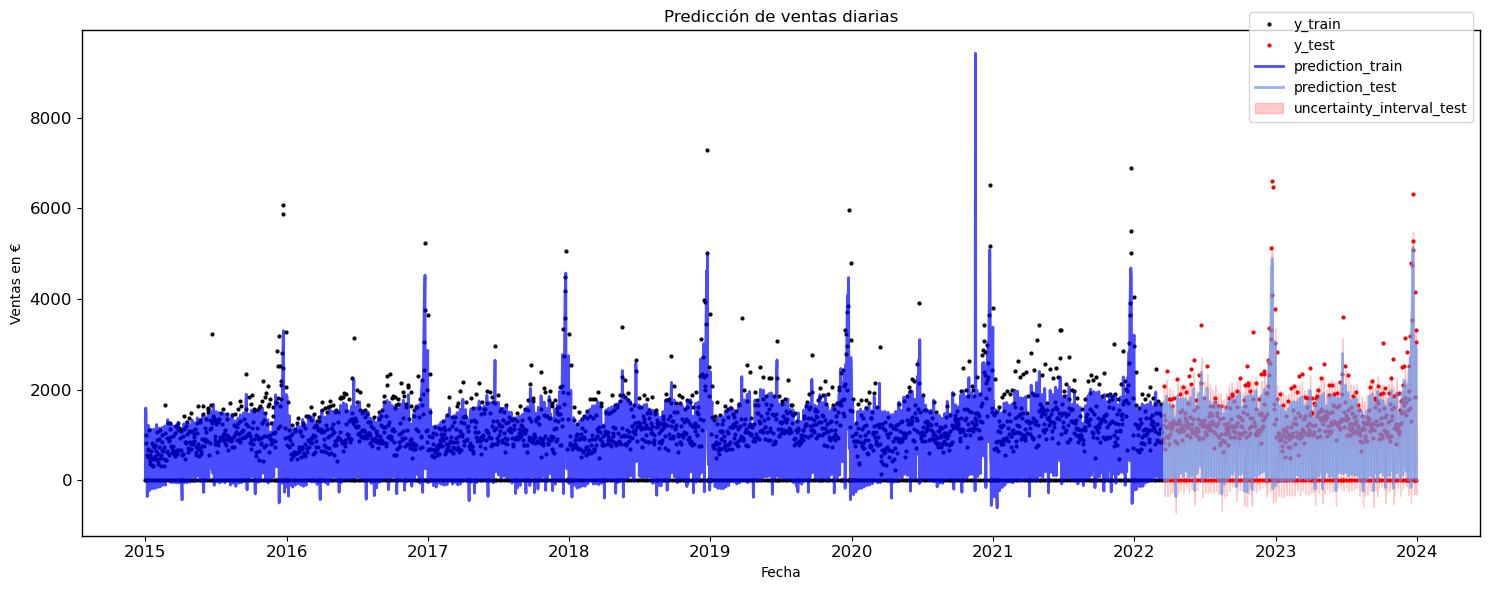

In [82]:
plt.close()
legend = ['y_train', 'y_test', 'prediction_train', 'prediction_test']

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(Factu_train['ds'], Factu_train['y'], c='black', marker='o', markersize=2, ls='')
ax.plot(Factu_test['ds'], Factu_test['y'], c='r', marker='o', markersize=2, ls='')
ax.plot(forecast_train['ds'], forecast_train['yhat'], ls='-', color='blue', alpha=0.7)
ax.plot(forecast_test['ds'], forecast_test['yhat'], ls='-', color='cornflowerblue', alpha=0.7)
ax.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='r', alpha=0.2)
legend.append('uncertainty_interval_test')
ax.legend(legend, bbox_to_anchor=(1.0, 1.05))
ax.set(title='Predicción de ventas diarias', xlabel='Fecha', ylabel='Ventas en €')
plt.tight_layout()
plt.show()

El gráfico muestra que las predicciones del modelo mantienen patrones muy similares a los reales (puntos negros y rojos), tanto en la frecuencia como en la intensidad de las olas. Las ventas en negativo corresponden a estimaciones del modelo en domingos y festivos que es cuando la tienda cierra, es decir, en estas fechas el modelo parece subestimar las ventas. 

En general el modelo parece ajustarse bastante bien a los patrones estacionales de los datos, pero el efecto de los domigos y festivos lo llevan a subestimar ligeramente las ventas en sus predicciones. 

**Predicciones para los próximos 2 años (2024 y 2025)**

In [83]:
fecha_final_deseada = pd.to_datetime('2025-12-31')
fechas_futuras = pd.date_range(start=Factu['ds'].max(), end=fecha_final_deseada, freq='D')
df_futuro = pd.DataFrame({'ds': fechas_futuras})
df_futuro['semanas_navidad'] = [True if ((dt - pd.Timedelta(days=5)).week == 50) or ((dt - pd.Timedelta(days=3)).week == 51) or ((dt - pd.Timedelta(days=3)).week == 52) or ((dt - pd.Timedelta(days=3)).week == 53)
                                  else False for dt in df_futuro['ds']]
df_futuro['semanas_normales'] = [False if ((dt - pd.Timedelta(days=5)).week == 50) or ((dt - pd.Timedelta(days=3)).week == 51) or ((dt - pd.Timedelta(days=3)).week == 52) or ((dt - pd.Timedelta(days=3)).week == 53)
                                  else True for dt in df_futuro['ds']]

df_futuro = df_futuro.drop(df_futuro.index[0])
df_futuro['Num Ventas'] = Factu['Num Ventas'].iloc[-1]

forecast_futuro = m.predict(df_futuro)

forecast_futuro.loc[forecast_futuro['ds'].isin(Festivos_futuros24['ds']), 'yhat'] = 0.0

print(forecast_futuro[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

            ds         yhat   yhat_lower   yhat_upper
0   2024-01-01     0.000000   119.482680   789.861281
1   2024-01-02  1277.818629   915.833392  1572.790134
2   2024-01-03  1425.869405  1100.157390  1748.252782
3   2024-01-04   839.239594   522.410217  1180.862930
4   2024-01-05  1159.612628   789.424581  1488.381697
..         ...          ...          ...          ...
726 2025-12-27  1427.461898  1073.662341  1779.709629
727 2025-12-28     0.000000  -417.324169   247.566385
728 2025-12-29  1609.507449  1267.458017  1931.967954
729 2025-12-30  1585.673769  1278.540665  1918.091830
730 2025-12-31  1697.511072  1387.286693  2016.197280

[731 rows x 4 columns]


Analizando las predicciones para los años 2024 y 2025 se observa que efectivamente las predicciones para la temporada de navidad están subestimadas. Lo mismo pasa con la mayoría de predicciones de domingos y días festivos. Estas predicciones aparecen en cero porque así lo he definido, pero el modelo sí ha hecho predicciones estos días y en general son negativas.   

Para el resto de la serie, la gran mayoría de dato dl día a día, las predicciones son bastante aceptables, aunque la mejor predicción estaría entre las predicciones de ventas del modelo y la banda alta del intervalo de confianza; es decir, también están subestimadas pero de manera muy ligera. 

Es probable que a pesar de haber añadido estacionalidades de navidad, la autocorrelación de los datos aún esté afectando las estimaciones provocando esta subestimación.

**Coeficiente de determinación y error cuadrático medio**

In [84]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

def metrics(Factu_train, forecast_train, Factu_test, forecast_test):
    MSE_metric = pd.DataFrame(index=['RMSE'],
                              data={'Train': [np.sqrt(mean_squared_error(y_true=Factu_train['y'], y_pred=forecast_train['yhat']))],
                                    'Test': [np.sqrt(mean_squared_error(y_true=Factu_test['y'], y_pred=forecast_test['yhat']))]})
    
    r2_metric = pd.DataFrame(index=['R2'],
                             data={'Train': [100*r2_score(y_true=Factu_train['y'], y_pred=forecast_train['yhat'])],
                                   'Test': [100*r2_score(y_true=Factu_test['y'], y_pred=forecast_test['yhat'])]})

    return pd.concat([MSE_metric, r2_metric])

metrics(Factu_train, forecast_train, Factu_test, forecast_test)

,Train,Test
RMSE,320.702821,286.902008
R2,82.472178,89.614183


Teniendo en cuenta que una parte importante de los errores medios se debe a los domingos, festivos y navidades; el RMSE del modelo tanto para el conjunto de entrenamiento como para el de prueba es bastante aceptable. 

Por otro lado, la diferencia entre el RMSE del conjunto de entrenamiento y de prueba es relativamente pequeña, el modelo no parece estar infliuenciado (no parece haber memorizado) por los datos de entrenamiento a pesar de su complejidad y ajustes a las peculiaridades de los datos de entrenamiento.

El coeficiente de determinación del modelo indica que está capturando una gran proporción de la variabilidad en los datos o lo que es lo mismo, existe una alta proporción de la variabilidad en la serie temporal que es explicada por el modelo. 

**Predicción un día en concreto dentro de los años 2024 y 2025.**  

Creo un dataframe con todas las fechas de la predicción y lo uno a las predicciones originales para tenerlo en el formato Prophet. Pongo en valor 0 las ventas de los domingos al igual que en los días festivos ya que la tienda está cerrada. Filtro la fecha deseada y le doy formato.  

In [85]:
fechas_prediccion = pd.date_range(start=forecast_futuro['ds'].min(), end=forecast_futuro['ds'].max(), freq='D')
df_prediccion_modificado = pd.DataFrame({'ds': fechas_prediccion})

df_prediccion_modificado = pd.merge(df_prediccion_modificado, forecast_futuro, on='ds', how='left')

df_prediccion_modificado.loc[df_prediccion_modificado['ds'].dt.dayofweek == 6, 'yhat'] = 0

fecha_deseada = pd.to_datetime('2025-04-24')
fecha_deseada_sin_hora = fecha_deseada.date()

prediccion_deseada = df_prediccion_modificado[df_prediccion_modificado['ds'] == fecha_deseada]['yhat'].values[0]
prediccion_deseada_redondeada = round(prediccion_deseada, 2)
prediccion_con_euro = f'{prediccion_deseada_redondeada:.2f} €'
print(f'Predicción para {fecha_deseada_sin_hora}: {prediccion_con_euro}')

Predicción para 2025-04-24: 811.26 €


Pensando en una herramienta que le sea útil al responsable de la tienda para tomar decisiones con base en la demanda esperada, este código permite dar una fecha para recibir como respuesta la facturación de ese día en concreto. 

Por ejemplo, si el responsable de la tienda se mira la facturación esperada de la semana siguiente, el lunes de esa semana puede hacer los pedidos basado en esa facturación esperada, puede cada día producir el pan y los loncheados necesarios y ajustar el personal, un paso para reducir costes (menos desperdicio), ajustar mejor los procesos de la tienda y, en definitiva, satisfacer la demanda de la forma más eficiente posible.   

#### **Conclusiones**

- El modelo ha conseguido proyectar de forma muy correcta las fluctuaciones temporales de los datos a pesar de la variedad y complejidad de las estacionalidades de la serie de tiempo. 

- En general el modelo predice el día a día de la tienda de forma bastante aceptable con una ligera tendencia a subestimarlo. Si al tomar deciciones para el día a día se considera la estimación y la banda alta del intervalo de confianza, las decisiones estarán basadas en datos bastante fiables. 

- Los domingos y días festivos, cuando la tienda está cerrada, el modelo subestima las ventas, deberían ser cero y en general predice valores negativos. Como he definido que estos días en las proyecciones sean cero, las proyecciones de ventas no se ven afectadas, pero como el modelo sí ha proyectado valores para estos días al entrenarlo, el RMSE se ve afectado aumentando su valor. 

- Los picos de demanda que se dan en la temporada navideña, también están subestimados por el modelo, esto también aumenta el RMSE y además hace que las proyecciones en estas temporadas (últimas tres semanas de cada año) no sean fiables. 

- A pesar de haber indicado al modelo la temporalidad navideña, es probable que la autocorrelación de la serie este provocando la subestimación, sobre todo de los días festivos, domingos y navidad.  

- El RMSE del modelo es aceptable considerando que esta afectado con fuerza por los valores estimdos para domingos, festivos y temporada navideña. Por su lado, el coeficiente de determinación (89.6 para el conjunto de prueba) explica una proporcion alta de la variabilidad en la serie temporal. 

#### **Posibles mejoras**

- Añadir regresores que afecten la demanda de la tienda, por ejemplo: meteorológicos, fiestas de barrio, competencia o costes. Esto podría mejorar las predicciones, sobre todo a corregir la subestimación. 

- Quitar los domingos para el entrenamiento del modelo. Según la documentación de Prophet, no hace falta quitar estos días porque ya los toma en cuenta. Aún así (sin quitar también los festivos del entrenamiento porque son pocos) los resultados muestran que gran parte de esta subestimación se debe a los domingos. Quitarlos de la serie, entrenar el modelo y recolocarlos en las predicciones con valor cero (si se cierra los domingos) sería un forma segura de reducir la subestimación y por tanto mejorar las predicciones.   

- Reducir la autocorrelación de la serie. Prophet utiliza técnicas de suvizado como promedios móviles ponderados o simples que incorporan la autocorrelación al modelo de forma automática o manual, aún así sería interesante: 

    - Usar un modelo de aprendizaje profundo LSMT para manejar la autocorrelación y comparar resutados. Este modelo también es capaz de aprender automáticamente dependencias temporales y adaptarse a una variedad de estacionalidades.

    - Comparar el resultado de trabajar con una serie sin autocorrelación para mejorar predicciones, sobre todo navideñas. Se podría:
        - Hacer diferenciación de primer orden o estacional.
        - Alguna transformación en los datos, tipo logarítmica o Box-Cox, aunque la documentación del modelo indica que no hace falta hacer transformaciones en los datos. 

#### **Bibliografía**

- "Deep Learning" de Ian Goodfellow, Yoshua Bengio y Aaron Courville.
- Varios modelos de series temporales. Producción de cerveza mensual, comparativa. https://www.kaggle.com/code/sergiomora823/time-series-analysis-arima-sarima-prophet-lstm
- https://deepnote.com/@b-anderson-diaz-4413/ProyectoPronostico-de-ventas-minoristas-con-modelo-ARIMA-e401bd72-e88d-4f03-ba67-e27d4f597bd5
- https://www.kaggle.com/code/royelbee/sales-prediction-using-python
- https://www.embedded-robotics.com/forecast-sales-using-machine-learning/
- https://cienciadedatos.net/documentos/py51-modelos-arima-sarimax-python
- https://towardsdatascience.com/predicting-sales-611cb5a252de
- Modelo Prophet. Sitio oficial. https://facebook.github.io/prophet/
- Modelo Prophet. Ventas diarias de un retalier online. https://www.paradigmadigital.com/dev/predecir-ventas-retail-series-temporales-prophet/  - Modelo Prophet. Demanda diaria de prodcuto. 
https://github.com/MartinOviedoR/Demand_Forecasting/blob/master/DemandaHabi.ipyn
- Modelo Prophet. n)
https://rpubs.com/Juan-Isaula/986679